This workshop describes an overview of machine learning. Basic concepts of supervised learning including regression, classification and optimisation (with hand-on experiments in computer lab) are covered.

Tu Bui - PhD student

Tu Bui is currently towards completion of his PhD at the University of Surrey, United Kingdom. He holds a BEng degree in Electronics Engineering. His research is mainly sketch-based visual search. His interests include computer vision, information retrieval, machine learning and deep learning.

# Introduction to Machine Learning (ML)
This tutorial aims to get you familiar with the basis of ML. You will go through several tasks to build some basic regression and classification models.

In [1]:
#essential imports
import sys
sys.path.insert(1,'utils')
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib nbagg
import pandas as pd
import ml_utils
print(np.__version__)
print(np.__file__)

1.12.1
/home/miky/anaconda3/lib/python3.6/site-packages/numpy/__init__.py


## 1. Linear regression
### 1. 1. Univariate linear regression
Let start with the most simple regression example. Firstly, read the data in a file named "house_price_statcrunch.xls".

In [2]:
house_data = pd.ExcelFile('data/house_price_statcrunch.xls').parse(0)

Let see what is inside by printing out the first few lines.

In [3]:
print(" ".join([field.ljust(10) for field in house_data.keys()]))
for i in range(10):
    print(" ".join([str(house_data[field][i]).ljust(10) for field in house_data.keys()]))
TOTALS = len(house_data['House'])
print("...\n\nTotal number of samples: {}".format(TOTALS))

House      Taxes      Bedrooms   Baths      Quadrant   NW         price      size       lot       
1          1360       3          2.0        NW         1          145000     1240       18000     
2          1050       1          1.0        NW         1          68000      370        25000     
3          1010       3          1.5        NW         1          115000     1130       25000     
4          830        3          2.0        SW         0          69000      1120       17000     
5          2150       3          2.0        NW         1          163000     1710       14000     
6          1230       3          2.0        NW         1          69900      1010       8000      
7          150        2          2.0        NW         1          50000      860        15300     
8          1470       3          2.0        NW         1          137000     1420       18000     
9          1850       3          2.0        NW         1          121300     1270       16000     
10        

Let preserve some data for test. Here we extract 10% for testing. 

In [4]:
np.random.seed(0)
idx = np.random.permutation(TOTALS)
idx_train = idx[:90]
idx_test = idx[90:]
house_data_train = {}
house_data_test = {}
for field in house_data.keys():
    house_data_test[field] = house_data[field][idx_test]
    house_data_train[field] = house_data[field][idx_train]

For univariate regression, we are interested in the "size" parameter only. Let's extract necessary data and visualise it.

<IPython.core.display.Javascript object>


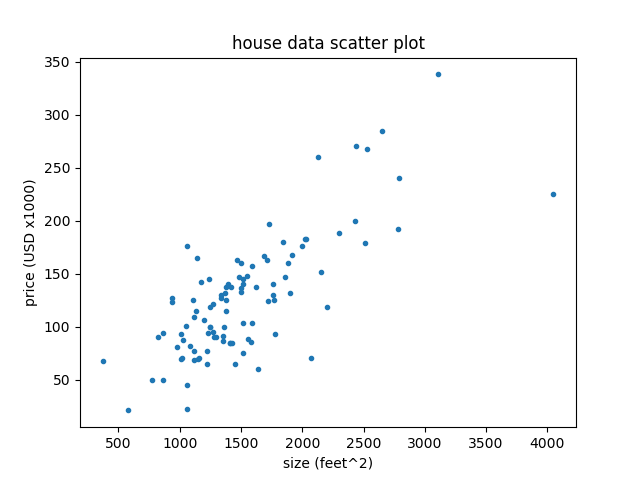

In [5]:
X, Z = ml_utils.extract_data(house_data, ['size'], ['price'])
Z = Z/1000.0  #price has unit x1000 USD

plt.plot(X[0],Z[0], '.')
plt.xlabel('size (feet^2)')
plt.ylabel('price (USD x1000)')
plt.title('house data scatter plot')

Our goal is to build a house price prediction model that will approximate the price of a house given its size. To do it, we need to fit a linear line (y = ax + b) to the data above using linear regression. Remember the procedure:
1. Define training set
2. Define hypothesis function. Here $F(x,W) = Wx$
3. Loss function. Here $L(W) = \frac{1}{2N}{\sum_{i=1}^N{(F(x^{(i)},W)-z)^2}}$
4. Update procedure (gradient descent). $W = W - k\frac{\partial L}{\partial W}$

To speed up computation, you should avoid using loop when working with scripting languges e.g. Python, Matlab. Try using array/matrix instead. Here you are provided code for step 1 and 2. Your will be asked to implement step 3 and 4. Some skeleton code will be provided for your convenience.

In [6]:
"""step 1: define training and test set X, Z."""
X_train, Z_train = ml_utils.extract_data(house_data_train, ['size'], ['price'])
X_test, Z_test = ml_utils.extract_data(house_data_test, ['size'], ['price'])

Z_train = Z_train/1000.0                        #price has unit x1000 USD
Z_test = Z_test/1000.0

##normalise data, uncomment for now
#X_train, u, scale = ml_utils.normalise_data(X_train)
#X_test = ml_utils.normalise_data(X_test, u, scale)

N = Z_train.size                                            #number of training samples
ones_array = np.ones((1,N),dtype=np.float32)
X_train = np.concatenate((X_train, ones_array), axis=0)           #why?
X_test  = np.concatenate((X_test, np.ones((1, Z_test.size), dtype=np.float32)), axis = 0) #same for test data
print("size of X_train ", X_train.shape)
print("size of Z_train ", Z_train.shape)

size of X_train  (2, 90)
size of Z_train  (1, 90)


In [7]:
"""step 2: define hypothesis function"""
def F_Regression(X, W):
    """
    Compute the hypothesis function y=F(x,W) in batch.
    input:  X  input array, must has size DxN (each column is one sample)
            W  parameter array, must has size 1xD
    output: linear multiplication of W*X, size 1xN
    """
    return np.dot(W,X)

**Task 1.1**: define the loss function for linear regression according to the following formula:
$$L = \frac{1}{2N}{\sum_{i=1}^N{(y^{(i)}-z^{(i)})^2}}$$
Please fill in the skeleton code below. Hints: (i) in Python numpy the square operator $x^2$ is implemented as x**2; (ii) try to use matrix form and avoid for loop

In [8]:
"""step 3: loss function"""
def Loss_Regression(Y, Z):
    """
    Compute the loss between the predicted (Y=F(X,W)) and the groundtruth (Z) values.
    input:   Y   predicted results Y = F(X,W) with given parameter W, has size 1xN
             Z   groundtruth vector Z, has size 1xN
    output:  loss value, is a scalar
    """
    
    N = float(Z.size)
    diff = Y-Z
    return 1/(2*N)*np.dot(diff, diff.T).squeeze()
    # computes a multiplication: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.squeeze.html

**Task 1.2**: compute gradient of the loss function w.r.t parameter W according to the following formula:<br>
$$\frac{\partial L}{\partial W} = \frac{1}{N}\sum_{i=1}^N{(y^{(i)}-z^{(i)})x^{(i)}}$$
Please fill in the skeleton code below.

In [9]:
"""step 4: gradient descent - compute gradient"""
def dLdW_Regression(X, Y, Z):
    """
    Compute gradient of the loss w.r.t parameter W.
    input:   X   input array, each column is one sample, has size DxN
             Y   predicted values, has size 1xN
             Z   groundtruth values, has size 1xN
    output:  gradient, has same size as W
    """
    #enter your code here
    N = float(Z.size)
    return 1/N * (Y-Z).dot(X.T)

Now we will perform gradient descent update procedure according to the following formula:
$$W = W - k\frac{\partial L}{\partial W}$$
Here we use fixed number of iterations and learning rate.

<IPython.core.display.Javascript object>


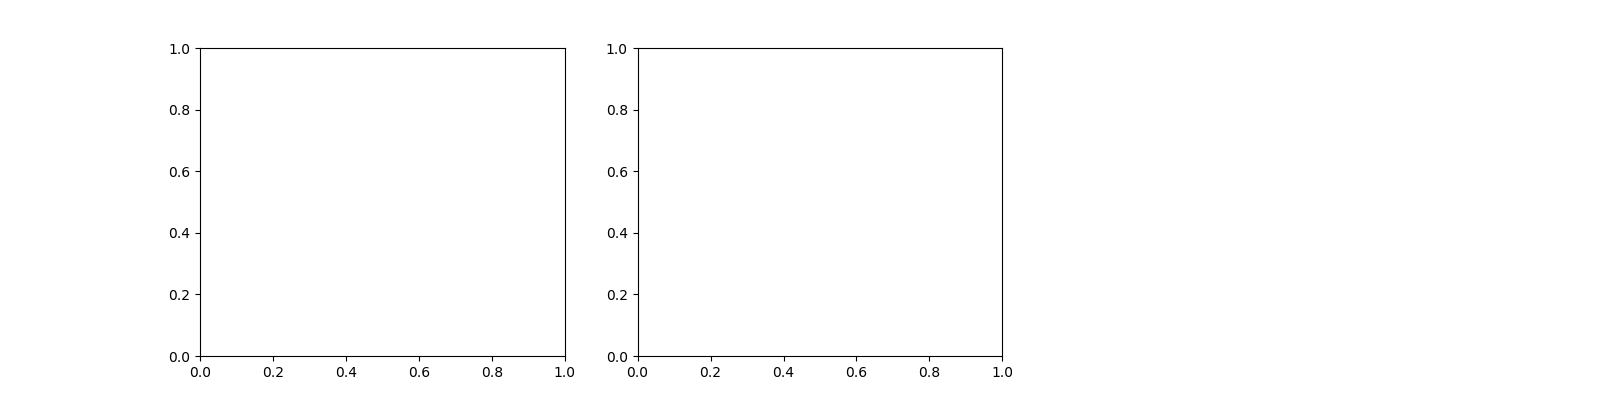

Learned parameters  [ 0.08923712  0.71492517]


In [10]:
"""step 4: gradient descent - update loop"""
np.random.seed(0)
W = np.random.rand(1,X_train.shape[0]).astype(np.float32)   #W has size 1xD, randomly initialised
k = 1e-8                                #learning rate
niters = 160                            #number of training iterations

#visualisation settings
vis_interval = niters/50
loss_collections = []
plt.close()
plt.ion()
fig = plt.figure(1,figsize=(16, 4))
axis_loss = fig.add_subplot(131)
axis_data = fig.add_subplot(132)
for i in range(niters):
    Y_train = F_Regression(X_train,W)               #compute hypothesis function aka. predicted values
    loss = Loss_Regression(Y_train, Z_train)         #compute loss
    dLdW = dLdW_Regression(X_train, Y_train, Z_train) #compute gradient
    W = W - k*dLdW                            #update
    loss_collections.append(loss)
    if (i+1)% vis_interval == 0:
        ml_utils.plot_loss(axis_loss, range(i+1),loss_collections, "loss = " + str(loss))
        ml_utils.plot_scatter_and_line(axis_data, X_train, Z_train, W, "iter #" + str(i))
        fig.canvas.draw()
print("Learned parameters ", W.squeeze())

Now evaluate your learned model using the test set. Measure the total error of your prediction

In [ ]:
Y_test = F_Regression(X_test, W)
error = Loss_Regression(Y_test, Z_test)
print "Evaluation error: ", error

**Quiz**: you may notice the learning rate k is set to $10^{-8}$. Why is it too small? Try to play with several bigger values of k, you will soon find out that the training is extremely sensitive to the learning rate (the training easily  diverges or even causes "overflow" error with large k). Why is that?<br><br>
Answer: It is because both the input (size of house) and output (price) have very large range of values, which result in very large gradient even with small k.

**Task 1.3**: Test your learned model. Suppose you want to sell a house of size 3000 $feat^2$, how much do you expect your house will cost?<br>
Answer: you should get around 260k USD for that house.

In [ ]:
x = 3000
#enter your code here to predict house price for x





**Task 1.4**: The gradient descent in the code above terminates after 100 iterations. You may want it to terminate when improvement in the loss is below a threshold.
$$\Delta L_t = |L_t - L_{t-1}| < \epsilon$$
Edit the code to terminate the loop when the loss improvement is below $\epsilon=10^{-2}$. Re-evaluate your model to see if its performance has improved.

In [ ]:
"""step 4: gradient descent - update loop"""
W = np.random.rand(1,X_train.shape[0]).astype(np.float32)   #W has size 1xD, randomly initialised
k = 1e-8                                #learning rate
epsilon = 1e-2                            #terminate condition

#enter your code here
#you may find it more convenient to copy the code (step 4: update loop with fixed iterations)
#  above and edit directly from it









In [ ]:
#run the test
Y_test = F_Regression(X_test, W)
error = Loss_Regression(Y_test, Z_test)
print "Evaluation error: ", error

Confirm that the error measurement on the test set has improved.

### 1.2 Multivariate regression
So far we assume the house price is affected by the size only. Now let consider also other fields "Bedrooms", "Baths", "lot" (location) and "NW" (whether or not the houses face Nothern West direction).<br><br>
**Important**: now your feature vector is multi-dimensional, it is crucial to normalise your training set for gradient descent to converge properly. The code below is almost identical to the previous step 1, except it loads more fields and implements data normalisation.

In [ ]:
"""step 1: define training set X, Z."""
selected_fields = ['size', 'Bedrooms', 'Baths', 'lot', 'NW']
X_train, Z_train = ml_utils.extract_data(house_data_train, selected_fields, ['price'])
X_test, Z_test = ml_utils.extract_data(house_data_test, selected_fields, ['price'])

Z_train = Z_train/1000.0                        #price has unit x1000 USD
Z_test = Z_test/1000.0

##normalise 
X_train, u, scale = ml_utils.normalise_data(X_train)
X_test = ml_utils.normalise_data(X_test, u, scale)

N = Z_train.size                                            #number of training samples
ones_array = np.ones((1,N),dtype=np.float32)
X_train = np.concatenate((X_train, ones_array), axis=0)           #why?
X_test  = np.concatenate((X_test, np.ones((1, Z_test.size), dtype=np.float32)), axis = 0) #same for test data
print("size of X_train ", X_train.shape)
print("size of Z_train ", Z_train.shape)(

Now run step 2-4 again. Note the followings: 
1. You need not to modify the *Loss_Regression* and *dLdW_Regression* functions. They should generalise enough to work with multi-dimensional data
2. Since your training samples are normalised you can now use much higher learning rate e.g. k = 1e-2
3. Note that the plot function *plot_scatter_and_line* will not work in multivariate regression since it is designed for 1-D input only. Consider commenting it out.<br>

**Question**: how many iterations are required to pass the threshold $\Delta L < 10^{-2}$ ?<br>
Answer: you should need ~4000 iterations (and it will take a while to complete).

**Task 1.5**: (a) evaluate your learned model on the test set. (b) Suppose the house you want to sell has a size of 3000 $feet^2$, has 3 bedrooms, 2 baths, lot number 10000 and in NW direction. How much do you think its price would be? Hints: don't forget to normalise the test sample.<br>

Answer: You will get ~150k USD only, much lower than the previous prediction based on size only. Your house has an advantage of size, but other parameters matter too.

In [ ]:
#enter your code here
# train multivariate regression model




# evaluate on test set





# test a single unknown sample





### 1.3 Gradient descent with momentum
**Task 1.6**: In the latest experiment, our training takes ~4000 iterations to converge. Now let try gradient descent with momentum to speed up the training. We will employ the following formula:
$$v_t = m*v_{t-1} + k\frac{\partial L}{\partial W}$$
$$W = W - v_t$$

In [ ]:
"""step 4: gradient descent with momentum - update loop"""
W = np.random.rand(1,X_train.shape[0]).astype(np.float32)   #W has size 1xD, randomly initialised
k = 1e-2                                #learning rate
epsilon = 1e-2                            #terminate condition
m = 0.9                                 #momentum
v = 0                                   #initial velocity

#enter your code here
# to implement update loop with momentum









## 2. Classification
In this part you will walk through different steps to implement several basic classification tasks.
### 2.1. Binary classification
Imagine you were an USP professor who teaches Computer Science. This year there is 100 year-one students who want to register your module. You examine their performance based on their scores on two exams. You have gone through the records of 80 students and already made admission decisions for them. Now you want to build a model to automatically make admission decisions for the rest 20 students. Your training data will be the exam results and admission decisions for the 80 students that you have assessed.<br><br>
Firstly, let load the data.

In [ ]:
student_data = pd.read_csv('data/student_data_binary_clas.txt', header = None, names=['exam1', 'exam2', 'decision'])
student_data

In [ ]:
#split train/test set
X = np.array([student_data['exam1'], student_data['exam2']], dtype=np.float32)
Z = np.array([student_data['decision']], dtype = np.float32)

#assume the first 80 students have been assessed, use them as the training data
X_train = X[:,:80]
X_test = X[:,80:]

#you later have to manually assess the rest 20 students according to the university policies.
# Great, now you have a chance to evaluate your learned model
Z_train = Z[:,:80]
Z_test = Z[:,80:]

#normalise data
X_train, u, scale = ml_utils.normalise_data(X_train)
X_test = ml_utils.normalise_data(X_test, u, scale)

#concatenate array of "1s" to X array
X_train = np.concatenate((X_train, np.ones_like(Z_train)), axis = 0)
X_test = np.concatenate((X_test, np.ones_like(Z_test)), axis = 0)

#let visualise the training set
plt.close()
plt.ion()
fig = plt.figure(1)
axis_data = fig.add_subplot(111)
ml_utils.plot_scatter_with_label_2d(axis_data, X_train, Z_train,msg="student score scatter plot")

**Task 2.1**: your first task is to define the hypothesis function. Do you remember what the hypothesis function in a binary classification task look like?
$$F(x,W) = \frac{1}{1+e^{-Wx}}$$

In [ ]:
def F_Classification(X, W):
    """
    Compute the hypothesis function given input array X and parameter W
    input:   X  input array, must has size DxN (each column is one sample)
             W  parameter array, must has size 1xD
    output:  sigmoid of W*X, size 1xN
    """
    #enter your code here
    
    
    
    
    
    pass

**Task 2.2**: define the loss function for binary classification. It is called "negative log loss":
$$L(W) = -\frac{1}{N} \sum_{i=1}^N{[z^{(i)} log(F(x^{(i)},W)) + (1-z^{(i)})(log(1-F(x^{(i)},W))]}$$

Next, define the gradient function:
$$\frac{\partial L}{\partial W} = \frac{1}{N}(F(X,W) - Z)X^T$$

In [ ]:
"""step 3: loss function for classification"""
def Loss_Classification(Y, Z):
    """
    Compute the loss between the predicted (Y=F(X,W)) and the groundtruth (Z) values.
    input:   Y   predicted results Y = F(X,W) with given parameter W, has size 1xN
             Z   groundtruth vector Z, has size 1xN
    output:  loss value, is a scalar
    """
    #enter your code here
    
    
    
    
    
    pass

"""step 4: gradient descent for classification - compute gradient"""
def dLdW_Classification(X, Y, Z):
    """
    Compute gradient of the loss w.r.t parameter W.
    input:   X   input array, each column is one sample, has size DxN
             Y   probability of label = 1, has size 1xN
             Z   groundtruth values, has size 1xN
    output:  gradient, has same size as W
    """
    #enter your code here
    
    
    
    
    
    pass

In [ ]:
"""step 4: gradient descent - update loop"""
W = np.random.rand(1,X_train.shape[0]).astype(np.float32)   #W has size 1xD, randomly initialised
k = 0.2                                #learning rate
epsilon = 1e-6                            #terminate condition
m = 0.9                                 #momentum
v = 0                                   #initial velocity

#visualisation settings
vis_interval = 10
loss_collections = []
prev_loss = 0
plt.close()
plt.ion()
fig = plt.figure(1,figsize=(16, 4))
axis_loss = fig.add_subplot(131)
axis_data = fig.add_subplot(132)
while(1):
    Y_train = F_Classification(X_train,W)               #compute hypothesis function aka. predicted values
    loss = Loss_Classification(Y_train, Z_train)         #compute loss
    dLdW = dLdW_Classification(X_train, Y_train, Z_train) #compute gradient
    v = v*m + k*dLdW
    W = W - v                            #update
    loss_collections.append(loss)
    if abs(loss - prev_loss) < epsilon:
        break
    prev_loss = loss
    if (len(loss_collections)+1) % vis_interval==0:
        ml_utils.plot_loss(axis_loss, range(len(loss_collections)),loss_collections, "loss = " + str(loss))
        ml_utils.plot_scatter_with_label_2d(axis_data, X_train, Z_train, W, "student score scatter plot")
        fig.canvas.draw()

print("Learned parameters ", W.squeeze())
print("Learning terminates after {} iterations".format(len(loss_collections)))

In [ ]:
#evaluate
Y_test = F_Classification(X_test, W)
predictions = Y_test > 0.5
accuracy = np.sum(predictions == Z_test)/float(Z_test.size)
print("Test accuracy: ", accuracy)

We achieve 90% accuracy (only two students have been misclassified). Not too bad, isn't it?

**Task 2.3**: regularisation
Now we want to add a regularisation term into the loss to prevent overfitting.
Regularisation loss is simply magnitude of the parameter vector W after removing the last element (i.e. bias doesn't count to regularisation).
$$L_R = \frac{1}{2}|W'|^2$$
where W' is W with the last element truncated.<br>

Now the total loss would be:
$$L(W) = -\frac{1}{N} \sum_{i=1}^N{[z^{(i)} log(F(x^{(i)},W)) + (1-z^{(i)})(log(1-F(x^{(i)},W))]} + \frac{1}{2}|W'|^2$$

The gradient become:
$$\frac{\partial L}{\partial W} = \frac{1}{N}(F(X,W) - Z)X^T + W''$$
where W'' is W with the last element change to 0.

Your task is to implement the loss and gradient function with added regularisation.

In [ ]:
"""step 3: loss function with regularisation"""
def Loss_Classification_Reg(Y, Z, W):
    """
    Compute the loss between the predicted (Y=F(X,W)) and the groundtruth (Z) values.
    input:   Y   predicted results Y = F(X,W) with given parameter W, has size 1xN
             Z   groundtruth vector Z, has size 1xN
             W   parameter vector, size 1xD
    output:  loss value, is a scalar
    """
    #enter your code here
    
    
    
    
    
    
    pass

"""step 4: gradient descent with regularisation - compute gradient"""
def dLdW_Classification_Reg(X, Y, Z, W):
    """
    Compute gradient of the loss w.r.t parameter W.
    input:   X   input array, each column is one sample, has size DxN
             Y   probability of label = 1, has size 1xN
             Z   groundtruth values, has size 1xN
             W   parameter vector, size 1xD
    output:  gradient, has same size as W
    """
    #enter your code here
    
    
    
    
    
    pass

Rerun the update loop again with the new loss and gradient functions. Note you may need to change the learning rate accordingly to have proper convergence. Now you have implemented both regularisation and momentum techniques, you can use a standard learning rate value of 0.01 which is widely used in practice.

In [ ]:
""" gradient descent with regularisation - parameter update loop"""
W = np.random.rand(1,X_train.shape[0]).astype(np.float32)   #W has size 1xD, randomly initialised
k = 0.01                                #learning rate
epsilon = 1e-6                            #terminate condition
m = 0.9                                 #momentum
v = 0                                   #initial velocity

#visualisation settings
vis_interval = 10
loss_collections = []
prev_loss = 0
plt.close()
plt.ion()
fig = plt.figure(1,figsize=(16, 4))
axis_loss = fig.add_subplot(131)
axis_data = fig.add_subplot(132)
for i in range(500):
    Y_train = F_Classification(X_train,W)               #compute hypothesis function aka. predicted values
    loss = Loss_Classification_Reg(Y_train, Z_train, W)         #compute loss
    dLdW = dLdW_Classification_Reg(X_train, Y_train, Z_train, W) #compute gradient
    v = v*m + k*dLdW
    W = W - v                            #update
    loss_collections.append(loss)
    if abs(loss - prev_loss) < epsilon:
        break
    prev_loss = loss
    if (len(loss_collections)+1) % vis_interval==0:
        ml_utils.plot_loss(axis_loss, range(len(loss_collections)),loss_collections, "loss = " + str(loss))
        ml_utils.plot_scatter_with_label_2d(axis_data, X_train, Z_train, W, "student score scatter plot")
        fig.canvas.draw()

print("Learned parameters ", W.squeeze())
print("Learning terminates after {} iterations".format(len(loss_collections)))

**Question**: Do you see any improvement in accuracy or convergence speed? Why?

Answer: Regularisation does help speed up the training (it adds stricter rules to the update procedure). Accuracy is the same (90%) is probably because (i) number of parameters to be trained is small (2-D) and so is the number of training samples; and (ii) the data are well separated. In a learning task which involves large number of parameters (such as neural network), regularisation proves a very efficient technique.

### 2.2 Multi-class classification
Here we are working with a very famous dataset. The Iris flower dataset has 150 samples of 3 Iris flower species (Setosa, Versicolour, and Virginica), each sample stores the height and length of its sepal and pedal in cm (4-D in total). Your task is to build a classifier to distinguish these flowers.

In [ ]:
#read the Iris dataset
iris = np.load('data/iris.npz')
X = iris['X']
Z = iris['Z']
print("size X ", X.shape)
print("size Z ", Z.shape)

#split train/test with ratio 120:30
TOTALS = Z.size
idx = np.random.permutation(TOTALS)
idx_train = idx[:120]
idx_test = idx[120:]

X_train = X[:, idx_train]
X_test = X[:, idx_test]
Z_train = Z[:, idx_train]
Z_test = Z[:, idx_test]

#normalise data
X_train, u, scale = ml_utils.normalise_data(X_train)
X_test = ml_utils.normalise_data(X_test, u, scale)

#concatenate array of "1s" to X array
X_train = np.concatenate((X_train, np.ones_like(Z_train)), axis = 0)
X_test = np.concatenate((X_test, np.ones_like(Z_test)), axis = 0)

**Task 2.4**: one-vs-all. Train 3 binary one-vs-all classifiers $F_i$ (i=1-3), one for each class. An unknown feture vector x belongs to class i if:
$$max_i F(x,W_i)$$

**Task 2.5**: implement one-vs-one and compare the results with one-vs-all.

In [ ]:
#enter your code here





